## OBJECTIVES ##
Basic Model

*This study only uses 3 variables to predict the mortality of the patients of COVID-19*

In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import svm
import matplotlib.pyplot as plt

C:\Users\chris\AppData\Local\Temp\ipykernel_4800\262213884.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_excel('time_series_375_preprocess_en.xls')
data.head(3)

,PATIENT_ID,RE_DATE,age,gender,Admission time,Discharge time,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,...,mean corpuscular hemoglobin,Activation of partial thromboplastin time,Hypersensitive c-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
0,1.0,2020-01-31 01:09:00,73,1,2020-01-30 22:12:47,2020-02-17 12:40:09,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2020-01-31 01:25:00,73,1,2020-01-30 22:12:47,2020-02-17 12:40:09,0,NaN,136.0,NaN,...,31.9,NaN,NaN,NaN,NaN,0.12,NaN,NaN,NaN,NaN
2,NaN,2020-01-31 01:44:00,73,1,2020-01-30 22:12:47,2020-02-17 12:40:09,0,NaN,NaN,103.1,...,NaN,NaN,43.1,NaN,137.7,NaN,NaN,16.0,46.6,130.0


In [3]:
data = data.drop(columns=['RE_DATE', 'Admission time', 'Discharge time'])
data = data.rename(columns={"PATIENT_ID": "id"})
data = data.ffill().drop_duplicates('id',keep='last')
data.head(3)

,id,age,gender,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),...,mean corpuscular hemoglobin,Activation of partial thromboplastin time,Hypersensitive c-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
23,1.0,73,1,0,19.9,131.0,100.0,12.4,0.09,1.7,...,32.3,38.9,2.6,0.09,142.7,0.16,41.0,30.0,74.7,88.0
52,2.0,61,1,0,1.9,149.0,98.1,12.3,0.09,0.1,...,32.2,36.0,27.4,0.09,137.4,0.27,40.0,22.0,94.6,74.0
70,3.0,70,2,0,1.9,126.0,102.2,13.6,0.06,0.1,...,33.3,34.8,3.6,0.10,143.2,0.23,29.0,67.0,84.6,64.0


**Normalize and remove Nans**

In [4]:
#Now we normalize
normalized=(data-data.mean())/data.std()
X = normalized.drop(['id', 'outcome'], axis=1)
y = data['outcome']
#We remove some NaNs.
X.dropna(axis=1, inplace=True)

In [5]:
train = data.filter(['id','outcome','(%)lymphocyte',
       'Lactate dehydrogenase','Hypersensitive c-reactive protein'])
train.head(10)

,id,outcome,(%)lymphocyte,Lactate dehydrogenase,Hypersensitive c-reactive protein
23,1.0,0,25.9,206.0,2.6
52,2.0,0,9.2,282.0,27.4
70,3.0,0,27.3,226.0,3.6
84,4.0,0,16.5,249.0,14.5
105,5.0,0,23.6,179.0,0.8
119,6.0,0,31.0,231.0,0.3
139,7.0,0,13.3,313.0,1.5
166,8.0,0,37.2,181.0,0.6
183,9.0,0,21.9,170.0,3.2
209,10.0,0,24.5,220.0,2.3


In [6]:
normalized_train=(train-train.mean())/train.std()
# little ugly but we want to maybe preserve id
normalized_train['id'] = train['id']
normalized_train.head(10)

,id,outcome,(%)lymphocyte,Lactate dehydrogenase,Hypersensitive c-reactive protein
23,1.0,-0.929173,0.708162,-0.658699,-0.779411
52,2.0,-0.929173,-0.559811,-0.477936,-0.472046
70,3.0,-0.929173,0.814459,-0.611130,-0.767017
84,4.0,-0.929173,-0.005548,-0.556425,-0.631926
105,5.0,-0.929173,0.533531,-0.722917,-0.801720
119,6.0,-0.929173,1.095387,-0.599238,-0.807917
139,7.0,-0.929173,-0.248513,-0.404204,-0.793044
166,8.0,-0.929173,1.566132,-0.718160,-0.804199
183,9.0,-0.929173,0.404456,-0.744323,-0.771975
209,10.0,-0.929173,0.601865,-0.625401,-0.783129


In [7]:
A = normalized_train.drop(['id', 'outcome'], axis=1)
B = train['outcome']

cv_shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

In [8]:
models = {
        "random_forest": RandomForestClassifier(random_state=0),
        "decision_tree" : DecisionTreeClassifier(random_state=0),
        "svm": svm.SVC()
}

scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']

In [9]:
metrics = {}
for name in models:
    model = models[name]
    print("training: ", name)
    result = cross_validate(model, A, B, cv=cv_shuffle, n_jobs=-1, scoring=scoring)
    metrics[name] = {}
    for x in result:
        metrics[name][x] = result[x].mean()
    # print(result)
print(metrics)

training:  random_forest
training:  decision_tree
training:  svm
{'random_forest': {'fit_time': 0.21377696990966796, 'score_time': 0.03195457458496094, 'test_accuracy': 0.9813333333333333, 'test_precision': 0.9748272195640617, 'test_f1': 0.9758497652582159, 'test_recall': 0.9772032902467686, 'test_roc_auc': 0.9990466086575926}, 'decision_tree': {'fit_time': 0.0, 'score_time': 0.012889862060546875, 'test_accuracy': 0.9546666666666667, 'test_precision': 0.9625225225225226, 'test_f1': 0.9450302697843682, 'test_recall': 0.9286969518105563, 'test_roc_auc': 0.9496622410874643}, 'svm': {'fit_time': 0.006820583343505859, 'score_time': 0.014706993103027343, 'test_accuracy': 0.9760000000000002, 'test_precision': 0.9574733824733824, 'test_f1': 0.9670679988499137, 'test_recall': 0.9772032902467686, 'test_roc_auc': 0.9916552684545599}}


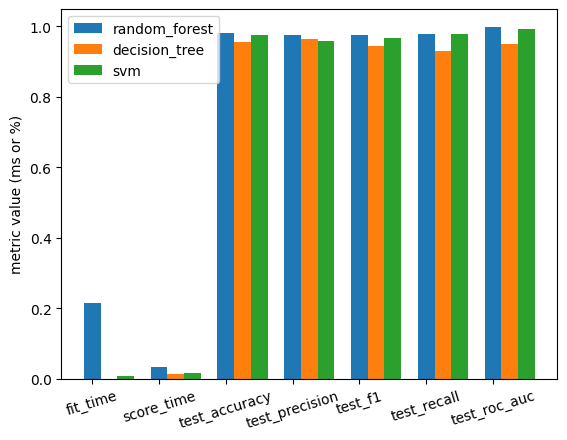

In [10]:
n=len(metrics['svm'])
r = np.arange(n)
width = 0.25
nr=0

# bars = []
for x in metrics:
    D = metrics[x]
    b = plt.bar(r + width*nr, list(D.values()), width=width, label = x)
    # bars.append(b)
    plt.xticks(range(len(D)), list(D.keys()))
    nr += 1

plt.ylabel("metric value (ms or %)")
plt.legend(models.keys())
plt.xticks(rotation=17)
plt.show()